In [59]:
%pylab inline

import numpy as np
import seaborn as sns

from graphviz import Digraph
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


# Introduction 

AlphaZero를 구현하기 위해서 정리한 문서입니다. <br>
아래는 AlphaZero의 특징입니다.

* Paper의 이름은 [Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm](https://arxiv.org/pdf/1712.01815.pdf)
* AlphaGoZero는 바둑만 되었는데, AlphaZero부터는 일반화된 모델을 제시하면서 페이퍼에서는 체스 그리고 일본 장기까지 섭렵하게 됨. (그래서 AlphaGoZero 에서 Go가 빠진 AlphaZero가 된듯함)
* Self-play reinforcement learning 으로서 Neural Network와 Monte Carlo Tree Search를 policy interation framework안에서 합친 알고리즘
* 사람의 domain knowledge없이 게임 방식만 알려주고 문제를 풀수있다. 
* 기존 방식보다 더 심플해졌다

# Monte Carlo Tree Search

![Demo](images/demo.gif)
<center>위의 데모는 MCTS를 사용해서 OpenAI의 택시 문제를 해결하였습니다.<br> 코드: https://github.com/AndersonJo/montecarlo-tree-search</center>

AlphaZero에서는 domain knowledge를 사용하는 alpha-beta search를 사용하는 것이 아니라, Monte Carlo Tree Search (MCTS) 알고리즘을 사용하여 general-purpose model을 만들었습니다. <br>
MCTS는 다음의 4가지 특징을 갖고 있습니다.


## Selection

Root node에서 시작을 해서 child node를 타고 타고 내려가기 시작합니다. <br>
타고 타고 내려가다가 **트리의 끝인 leaf node에 도착하게 되면 selection은 멈추게 됩니다**. <br>

트리를 traversal할때 중요한 2가지 항목을 만족시켜야 합니다.<br>
첫번재는 exploration으로서 아직 가보지 않은 길을 감으로서 새로운 정보를 얻습니다.<br>
두번째는 exploitation으로서 기존의 정보를 이용하여 좋은 길(child node)을 선택하는 것입니다. <br>
따라서 selection function은 이 두가지 exploration과 exploitation을 최적으로 만족시키는 방식을 취해야 합니다. 

이때 사용하는 방식이 바로 UCB1(Upper Confidence Bound 1)이라는 함수인데, <br>
이 함수가 MCTS와 함께 사용된 알고리즘이 바로 UCT (Upper Confidence Bound 1 applied to Trees)라는 함수 입니다.<br>
공식은 다음과 같습니다.


$$ \mathbb{UCT}(w_i, n_i) = \frac{w_i}{n_i} + c \sqrt{ \frac{\ln t}{ n_i}}  $$

* $ \frac{w_i}{n_i} $: **exploitation component**라고 하며, winning/losing 의 비율
* $ w_i $: i번째 **자식 노드의 이긴 횟수** (number of wins)
* $ n_i $: i번째 **자식 노드의 방문 횟수** 또는 시뮬레이션 횟수 (number of simulations)
* $ \sqrt{ \frac{\ln t}{ n_i}} $: **exploration component**라고 하며, exploitation component만 사용하게 되면 오직 simulation에서 이겼던 기록이 있는 노들만 따라가기 때문에 생겨나는 문제를 해결.
* $ t $: **부모(현재) 노드의 방문 회수 또는 시뮬레이션 횟수** (number of simulations for the parent node)
* $ c $: **exploration component**의 가중치로 생각하면 되며 보통 $ \sqrt{2} $ 를 사용


> UCT를 사용하지 않고 단순 랜덤으로 선택을 할 경우 exploration에는 매우 좋지만, 기존의 정보를 활용하는 exploitation에는 매우 안 좋습니다.
> 또한 각각의 node마다의 평균 승률을 사용하는 방법은 exploitation에 좋지만, exploration에는 좋은 방법이 아닙니다.


exploration component의 직관적인 이해는 `방문이 상대적으로 적은 노드`를 선택하도록 유도를 하게 됩니다.<br>
예를 들어서 아래의 경우 현재 노드 (부모 노드)의 방문 t=5000 일때, 자식노드의 방문횟수에 따른 그래프는 다음과 같습니다.


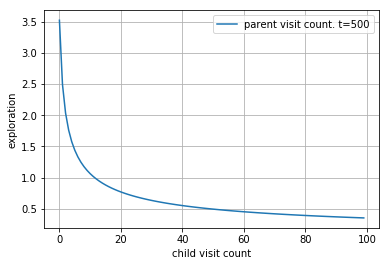

In [3]:
def exploration_component(t, x):
    c = np.sqrt(2)
    return c * np.sqrt(np.log(t) / (x+1))

x = np.arange(0, 100)
y = exploration_component(t=500, x=x)
lp = sns.lineplot(x, y, label='parent visit count. t=500')
lp.set(xlabel='child visit count', ylabel='exploration')
grid()

즉 매우 드물게 방문한 노드(액션)일수록 선택할 확률값이 올라가게 됩니다.

## Expansion

Selection에 leaf node에 도착해서 멈추게 되면, 최소한 한개의 가보지 않은 move (또는 action)이 있을 것 입니다.<br>
이때는 그냥 랜덤으로 unexpanded move를 선택하고 새로운 child node를 생성합니다. <br>
해당 child node는 selection phase에서 중단된 마지막 leaf node에 자식노드로 연결을 시킵니다. <br>
child node의 초기화 세팅은 승률은 $ w_i = 0 $, 그리고 방문 횟수는 $ n_i = 0 $ 으로 초기화 시킵니다.

구현상의 중요 포인트는, expansion시에 모든 action (또는 move)에 대해서 한꺼번에 만들어줄 필요는 없습니다. <br>
expansion마다 하나의 child node를 만들어주는게 효율적입니다. 

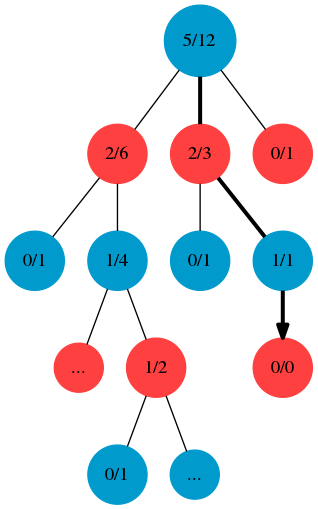

In [195]:
g = Graph('G', format='png')
g.attr('node', shape='circle')

# Root
g.node('root', '5/12',  color='deepskyblue3', style='filled')

# Second 
g.node('1-1', '2/6', color='brown1', style='filled')
g.edge('root', '1-1')

g.node('1-2', '2/3', color='brown1', style='filled')
g.edge('root', '1-2', penwidth='3')

g.node('1-3', '0/1', color='brown1', style='filled')
g.edge('root', '1-3')

# Part 1
g.node('2-1', '0/1', color='deepskyblue3', style='filled')
g.edge('1-1', '2-1')

g.node('2-2', '1/4', color='deepskyblue3', style='filled')
g.edge('1-1', '2-2')

# Part 1 - Child 1
g.node('3-1', '...', color='brown1', style='filled')
g.edge('2-2', '3-1')

g.node('3-2', '1/2', color='brown1', style='filled')
g.edge('2-2', '3-2')

# Part 1 - Child 2
g.node('4-1', '0/1', color='deepskyblue3', style='filled')
g.edge('3-2', '4-1')

g.node('4-2', '...', color='deepskyblue3', style='filled')
g.edge('3-2', '4-2')

# Part 2 - Child 1
g.node('p2-1', '0/1', color='deepskyblue3', style='filled')
g.edge('1-2', 'p2-1')

g.node('p2-2', '1/1', color='deepskyblue3', style='filled')
g.edge('1-2', 'p2-2',  penwidth='3')

# Part 2 - Child 2
g.node('p2-3', '0/0', color='brown1', style='filled')
g.edge('p2-2', 'p2-3', dir='forward', arrowtail='normal', penwidth='3')

Image(g.pipe())

## Simulation 

자~ expansion phase에서 새롭게 만들어진 자식노드에서 계속 진행하겠습니다. <br>
정말 쉽게 설명하기 위해서 엔지니어적으로 설명하면.. 현재 상태의 트리를 하나 더 복사합니다. <br>
그리고 selection 그리고 expansion을 전에 새롭게 만들어진 자식 노드에서 k번 반복시킵니다. <br> 
즉.. 랜덤으로 하나 move를 선택하고 다시 expansion하고 또 랜덤으로 하나 move를 선택하고 다시 expansion하고.. <br>
이 과정을 복사된 트리에서 진행을 합니다. (즉 원본 트리는 변경된 내용이 전혀 없습니다)<br>
또한 그 과정은 게임을 끝날때까지 k번 반복 시킵니다. 

> 문제만다 다르기는 하지만.. 일반적으로 빠르게 학습시키기 위해서 k=1 로 설정을 하기도 합니다. <br>
> 다만 예측률을 극도로 높이고 할때는 k를 높이면 되고, 실제 AlphaGo의 경우 한번의 simulation마다 k=1600 으로 하기도 했으며, AlphaZero의 경우 k=800으로 했다고 페이퍼에서 말하고 있습니다. (Paper: "During training, each MCTS used 800 simulations")<br>
> 또한 simulation 자체가 극단적으로 큰 computation power를 요구하기 때문에 엔지니어링적으로 효율적으로 돌릴수 있도록 멀티쓰레드 또는 distributed computation을 적극적으로 활용해야 합니다. 

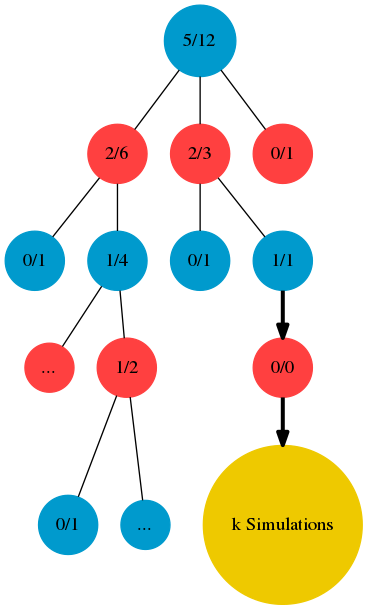

In [199]:
g = Graph('G', format='png')
g.attr('node', shape='circle')

# Root
g.node('root', '5/12',  color='deepskyblue3', style='filled')

# Second 
g.node('1-1', '2/6', color='brown1', style='filled')
g.edge('root', '1-1')

g.node('1-2', '2/3', color='brown1', style='filled')
g.edge('root', '1-2')

g.node('1-3', '0/1', color='brown1', style='filled')
g.edge('root', '1-3')

# Part 1
g.node('2-1', '0/1', color='deepskyblue3', style='filled')
g.edge('1-1', '2-1')

g.node('2-2', '1/4', color='deepskyblue3', style='filled')
g.edge('1-1', '2-2')

# Part 1 - Child 1
g.node('3-1', '...', color='brown1', style='filled')
g.edge('2-2', '3-1')

g.node('3-2', '1/2', color='brown1', style='filled')
g.edge('2-2', '3-2')

# Part 1 - Child 2
g.node('4-1', '0/1', color='deepskyblue3', style='filled')
g.edge('3-2', '4-1')

g.node('4-2', '...', color='deepskyblue3', style='filled')
g.edge('3-2', '4-2')

# Part 2 - Child 1
g.node('p2-1', '0/1', color='deepskyblue3', style='filled')
g.edge('1-2', 'p2-1')

g.node('p2-2', '1/1', color='deepskyblue3', style='filled')
g.edge('1-2', 'p2-2')

# Part 2 - Child 2
g.node('p2-3', '0/0', color='brown1', style='filled')
g.edge('p2-2', 'p2-3', dir='forward', arrowtail='normal', penwidth='3')

# Simulation
g.node('simulation', 'k Simulations', color='gold2', style='filled')
g.edge('p2-3', 'simulation', dir='forward', arrowtail='normal', penwidth='3')

Image(g.pipe())

## Backpropagation 

Simulation phase가 k번 돌고 완료된 후, selection에서 중단된 leaf node의 부모노드 -> 부모노드 -> 부모노드 계속 타고 가면서 업데이트를 시켜줍니다. 자! 무엇을 업데이트 시키냐하면.. 방문 횟수 $ n_i = k $ (simulation돌린만큼 방문횟수를 증가시킴) 그리고 이긴 횟수를 증가시켜야 되는데.. 여기서 좀 복잡합니다. 

아래 그래프에서 보면, Blue가 이겼습니다.<br>
방문횟수는 backprogagation을 하면서 모든 parent nodes를 k simulation만큼 증가 시켜주었는데, <br>
이긴 횟수는 red쪽이 증가 되었습니다.<br>

상식적으로는 blue가 이겼으니까, blue node의 이긴 횟수가 증가되어야 할거 같지만, <br> 
예를 들어 Blue node에 있을때, 어떤 자식 노드들(Red)를 선택해야지 Blue가 이길확률이 높일지를 생각해봤을때.. <br>
Blue의 자식노드들인 Red에다가 이긴 횟수를 증가시켜주는 것이 맞습니다. 

UCT공식을 생각하면 당연한 것이 되죠.

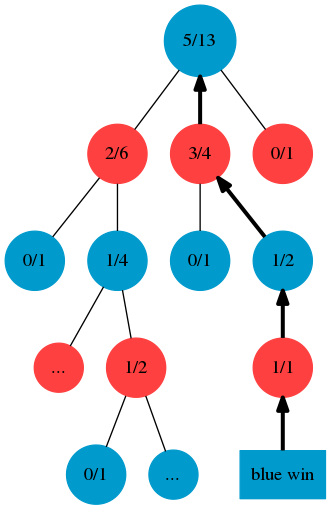

In [220]:
g = Graph('G', format='png')
g.attr('node', shape='circle')

# Root
g.node('root', '5/13',  color='deepskyblue3', style='filled')

# Second 
g.node('1-1', '2/6', color='brown1', style='filled')
g.edge('root', '1-1')

g.node('1-2', '3/4', color='brown1', style='filled')
g.edge('root', '1-2', dir='back', arrowtail='normal', penwidth='3')

g.node('1-3', '0/1', color='brown1', style='filled')
g.edge('root', '1-3')

# Part 1
g.node('2-1', '0/1', color='deepskyblue3', style='filled')
g.edge('1-1', '2-1')

g.node('2-2', '1/4', color='deepskyblue3', style='filled')
g.edge('1-1', '2-2')

# Part 1 - Child 1
g.node('3-1', '...', color='brown1', style='filled')
g.edge('2-2', '3-1')

g.node('3-2', '1/2', color='brown1', style='filled')
g.edge('2-2', '3-2')

# Part 1 - Child 2
g.node('4-1', '0/1', color='deepskyblue3', style='filled')
g.edge('3-2', '4-1')

g.node('4-2', '...', color='deepskyblue3', style='filled')
g.edge('3-2', '4-2')

# Part 2 - Child 1
g.node('p2-1', '0/1', color='deepskyblue3', style='filled')
g.edge('1-2', 'p2-1')

g.node('p2-2', '1/2', color='deepskyblue3', style='filled')
g.edge('1-2', 'p2-2', dir='back', arrowtail='normal', penwidth='3')

# Part 2 - Child 2
g.node('p2-3', '1/1', color='brown1', style='filled')
g.edge('p2-2', 'p2-3', dir='back', arrowtail='normal', penwidth='3')

# Simulation
g.node('win', 'blue win', color='deepskyblue3', style='filled', shape='polygon')
g.edge('p2-3', 'win', dir='back', arrowtail='normal', penwidth='3')

Image(g.pipe())

### 그래서 이게 AlphaZero와 뭔 상관?

도메인 지식을 알고서 만드는 alpha-beta search를 사용하는 방법이 아니라, AlphaZero는 general-purpose MCTS 알고리즘을 사용합니다. MCTS처럼 self-play를 하면서 simulation을 하게 됩니다. 각각의 simulation마다 action에 대한 선택은, 적게 방문하고 (low visit count), 높은 이동 확률 (high move probability), 그리고 높은 이기는 가치 (어떤 action을 했을때 해당 노드에서 계속 따라가서 최종 마지막 노드들에서의 평균값. averaged over the leaf states of simulations that selected a from s)를 갖는 액션을 뉴럴 네트워크를 통해서 선택하게 됩니다.

그래서 최종적으로 search가 끝나게 되면 vector 형태로 각 action (or move)에 대한 확률 분포를 나타내는 $ \boldsymbol{\pi} $ 를 리턴시키게 됩니다.

# Alpha Zero

## Neural Network



AlphaZero는 기존의 handcrafted evaluation function대신에 deep neural network를 사용합니다.

$$ (\mathbf{p}, v) = f_{\theta}(s) $$

* parameter $ \theta $ 를 사용 
* 게임 보드의 상태값인 $ s $ 를 deep neural network의 input값으로 사용
* outputs (2개)
  * $ \mathbf{p} $: a vector of move probabilities
    * 가능한 모든 actions들에 대한 vector라고 보면 됨
    * 각각의 요소들 (components)은 action을 나타냄 $ p_a = Pr(a | s) $
  * $ v $ : scalar value (continuous value)
    * state가 주어졌을때 게임을 이길지 질지에 대한 기대치
    * board state에 대해서 게임 결과에 대한 기대치 (expected outcome) $ z $ 를 구함
    * $ v_{\theta}(s) \in [-1, 1] $ 그리고 $ v \sim \mathbb{E}[z|s] $ 
* action probabilities 그리고 가치 평가 (value estimates)을 self-play로 학습을 함  
  
  
위에서 이야기 했듯이 MCTS의 search가 끝나게 되면 어떤 액션을 취해야 이길지 확률분포를 갖은 벡터 $ \mathbf{\pi} $ 를 리턴시키게 됩니다. 그리고 해당 리턴에서 가장 확률이 높은 action을 취해서 움직입니다. $ a_t \sim \mathbf{\pi}_t $<br>

## Loss Function

$$ l = (z-v)^2 - \boldsymbol{\pi}^T \log(\mathbf{p}) + c \| \theta \|^2 $$ 

* $ z $: 게임의 결과 점수
  * 이겼을때 1점
  * 비겼을때 0점
  * 졌을때 -1점
* $ v $: 게임 결과 점수 $ z $ 에 대한 예측값. 즉.. $ v_{\theta}(s_t) $
* $ (z-v) $: Neural network $ \theta $ 는 predicted outcome $ v_t $ 와 실제 게임의 결과값 (game outcome) $ z_t $의 차이를 최소화 (minimize)하도록 업데이트 됩니다.
* $ \boldsymbol{\pi}^T \log(\mathbf{p}) $: Policy vector $ \mathbf{p}_t $ 그리고 search probabilities $ \boldsymbol{\pi} $ 의 유사성을 최대화하도락 합니다. 즉 현재 state에서 어떤 action이 가장 좋은지 policy를 학습시키는 것 입니다. 다르게 써보면.. $ \boldsymbol{\pi} \cdot \log( P_{\theta} (s_t)) $
* Neural Network $ \theta $는 mean-squared error와 cross-entropy loss의 각각의 합을 loss function으로서 사용해서 gradient descent를 이용해서 학습하게 됩니다.
* $ c $: $ L_2 $ weight regularisation 에 대한 level controlling parameter. 

## Training

아래는 알파고제로와 알파제로가 다른점 입니다. <br> 
다르게 말하면 학습과정이 다르다는 뜻입니다.


1. 알파고제로는 바둑만 했기 때문에, 학습중 바둑판을 회전시키셔 data augmentation을 했지만, 알파제로는 바둑 뿐만 아니라, 체스 그리고 일본식 장기도 하여, 회전시키지 않고 학습
2. 알파고제로에서는 self-play게임을 best player와 new player와 싸움시켜서 new player가 55%이상 이기면 best player를 대체하는 방식. 알파제로에서는 하나의 뉴럴 네트워크를 그대로 사용해서 학습을 시킴. 
3. 알파고제로에서는 Bayesian optimization을 통해서 hyper-parameter tuning을 하였지만, 알파제로에서는 동일한 hyper-parameters를 갖고서 특정 게임에 튜닝하지 않고 계속 사용해서 학습

# References

* https://arxiv.org/pdf/1712.01815.pdf
* https://web.stanford.edu/~surag/posts/alphazero.html